In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Pfade zu den Bildern und Masken
image_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Trainingsbilder erweitert/'
mask_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Trainingsmasken erweitert/'

# Liste der Bild- und Maskenpfade
image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

# Laden und Vorverarbeiten der Daten mit Pillow
def load_and_preprocess_image_pillow(img_path):
    img = Image.open(img_path)
    img = img.resize((256, 196))  # Größe anpassen (Beispiel: 256x196)
    img = np.array(img)  # PIL Image zu numpy Array konvertieren
    img = img / 255.0  # Normalisierung auf den Bereich [0, 1]
    img = np.expand_dims(img, axis=-1)  # Für einen Kanal (Grayscale)
    return img

def load_and_preprocess_mask_pillow(mask_path):
    mask = Image.open(mask_path)
    mask = mask.resize((256, 196))  # Größe anpassen (Beispiel: 256x196)
    mask = np.array(mask)  # PIL Image zu numpy Array konvertieren
    mask = np.where(mask > 128, 1, 0)  # Binarisierung der Maske
    mask = np.expand_dims(mask, axis=-1)  # Für einen Kanal (Grayscale)
    return mask

# Liste für Bilder und Masken initialisieren
X = []
Y = []

# Bilder und Masken laden und in die Listen einfügen
for img_path, mask_path in zip(image_paths, mask_paths):
    img = load_and_preprocess_image_pillow(img_path)
    mask = load_and_preprocess_mask_pillow(mask_path)
    X.append(img)
    Y.append(mask)
    
# In NumPy Arrays konvertieren
X = np.array(X)
Y = np.array(Y)

# Überprüfen der Formen (optional)
print(f'Form von X vorher: {X.shape}')
print(f'Form von Y vorher: {Y.shape}')

# Modell erstellen für den Hyperparameter Tuner
def build_model(hp):
    inputs = Input(shape=(196, 256, 1))
    x = Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32), kernel_size=3, activation='relu', padding='same')(inputs)
    x = Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1))(x)
    x = Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=32), kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    
    x = Conv2D(filters=hp.Int('conv_3_filter', min_value=64, max_value=256, step=64), kernel_size=3, activation='relu', padding='same')(x)
    x = Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1))(x)
    x = Conv2D(filters=hp.Int('conv_4_filter', min_value=64, max_value=256, step=64), kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = Conv2D(filters=hp.Int('conv_5_filter', min_value=128, max_value=512, step=128), kernel_size=3, activation='relu', padding='same')(x)
    x = Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1))(x)
    x = Conv2D(filters=hp.Int('conv_6_filter', min_value=128, max_value=512, step=128), kernel_size=3, activation='relu', padding='same')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(filters=hp.Int('conv_7_filter', min_value=64, max_value=256, step=64), kernel_size=3, activation='relu', padding='same')(x)
    x = Dropout(rate=hp.Float('dropout_4', min_value=0.1, max_value=0.5, step=0.1))(x)
    x = Conv2D(filters=hp.Int('conv_8_filter', min_value=64, max_value=256, step=64), kernel_size=3, activation='relu', padding='same')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(filters=hp.Int('conv_9_filter', min_value=32, max_value=128, step=32), kernel_size=3, activation='relu', padding='same')(x)
    x = Dropout(rate=hp.Float('dropout_5', min_value=0.1, max_value=0.5, step=0.1))(x)
    x = Conv2D(filters=hp.Int('conv_10_filter', min_value=32, max_value=128, step=32), kernel_size=3, activation='relu', padding='same')(x)
    outputs = Conv2D(filters=1, kernel_size=3, activation='sigmoid', padding='same')(x)
    
    model = Model(inputs, outputs)
    
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss='binary_crossentropy')
    return model

# Hyperband Tuner konfigurieren
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,  # Maximal mögliche Epochen für das endgültige Modell
    factor=3,       # Faktor für die Reduktion der Anzahl der Versuche
    directory='my_dir',
    project_name='spheroid_segmentation'
)

# EarlyStopping-Callback hinzufügen
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)  # Erhöhe die Geduld

# Hyperparameter-Suche
tuner.search(X, Y, epochs=20, validation_split=0.1, callbacks=[early_stopping])

# Beste Hyperparameter anzeigen
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Beste Hyperparameter: {best_hps.values}")

# Beste Modell mit besten Hyperparametern bauen
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X, Y, batch_size=16, epochs=500, validation_split=0.1, callbacks=[early_stopping])

# Pfad zum Speichern des Modells im HDF5-Format
best_model.save('C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_best_model.h5') 

# Überprüfen der Formen (optional)
print(f'Form von X nachher: {X.shape}')
print(f'Form von Y nachher: {Y.shape}')

def plot_training_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(history)


Trial 8 Complete [00h 10m 44s]
val_loss: 0.598334550857544

Best val_loss So Far: 0.28497204184532166
Total elapsed time: 01h 29m 42s

Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
32                |64                |conv_1_filter
0.2               |0.1               |dropout_1
32                |32                |conv_2_filter
128               |128               |conv_3_filter
0.5               |0.2               |dropout_2
192               |192               |conv_4_filter
512               |128               |conv_5_filter
0.1               |0.1               |dropout_3
512               |128               |conv_6_filter
128               |256               |conv_7_filter
0.4               |0.3               |dropout_4
192               |64                |conv_8_filter
32                |96                |conv_9_filter
0.2               |0.4               |dropout_5
32                |128               |conv_10_filter
0.0001            |0.001 

: 

Anzahl der manuellen Durchmesser: 357
Anzahl der TIFF-Dateien: 357
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Segmentiertes Bild für 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS + P1 C6_ch00.tif wurde gespeichert.
Bild: 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS + P1 C6_ch00.tif, Durchmesser: 159.46 µm, Flächeninhalt: 19580.72 µm²
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
Segmentiertes Bild für 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS + P1 D6_ch00.tif wurde gespeichert.
Bild: 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS + P1 D6_ch00.tif, Durchmesser: 161.25 µm, Flächeninhalt: 20018.14 µm²
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
Segmentiertes Bild für 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS +P1 E6_ch00.tif wurde gespeichert.
Bild: 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS +P1 E6_ch00.tif, Durchmesser: 151.44 µm, Flächeninhalt: 17661.32 µm²
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
Segmentiertes Bild für 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS B4_ch00.tif wurde gesp

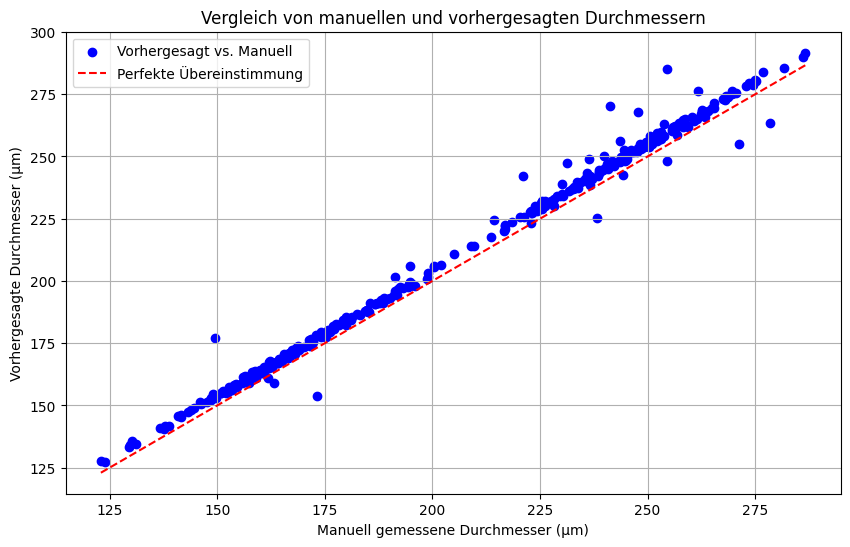

In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Laden und Vorverarbeiten der Bilder mit Pillow
def load_and_preprocess_image_pillow(img_path):
    img = Image.open(img_path).convert('L')  # Convert to grayscale
    img = img.resize((256, 196))  # Größe anpassen (Beispiel: 256x196)
    img = np.array(img)  # PIL Image zu numpy Array konvertieren
    img = img / 255.0  # Normalisierung auf den Bereich [0, 1]
    img = np.expand_dims(img, axis=-1)  # Für einen Kanal (Grayscale)
    return img

# Vorhersage mit dem Modell machen
def predict_with_model(model, image):
    image = np.expand_dims(image, axis=0)  # Batch-Dimension hinzufügen
    predicted_mask = model.predict(image)  # Vorhersage machen
    return np.squeeze(predicted_mask)  # Batch-Dimension entfernen

# Funktion zur Berechnung der mittleren Konturgröße
def calculate_average_contour_size(contour):
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0:
        return 0
    return cv2.contourArea(contour) / perimeter

# Funktion zur Auswahl des besten Schwellenwerts
def find_best_threshold(mask):
    best_threshold = 0
    best_score = 0

    for threshold in np.arange(0.1, 0.5, 0.01):
        binary_mask = (mask > threshold).astype(np.uint8) * 255  # Binarisieren und in 8-bit konvertieren
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            avg_size = calculate_average_contour_size(largest_contour)
            score = avg_size  # Anpassen der Bewertungsmetrik nach Bedarf

            if score > best_score:
                best_score = score
                best_threshold = threshold

    return best_threshold

# Funktion zur Berechnung des mittleren Durchmessers
def calculate_average_diameter(contour, center, num_lines=180):
    angles = np.linspace(0, 2 * np.pi, num=num_lines, endpoint=False)
    diameters = []
    for angle in angles:
        dx = np.cos(angle)
        dy = np.sin(angle)
        intersections = []
        for i in range(-1000, 1000):
            x = int(center[0] + i * dx)
            y = int(center[1] + i * dy)
            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:
                intersections.append((x, y))
        if len(intersections) >= 2:
            d = np.linalg.norm(np.array(intersections[0]) - np.array(intersections[-1]))
            diameters.append(d)
    return np.mean(diameters)


# Pfade definieren
model_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_200_trainingsbilder_noch_komplexer_early_stop_and_droput_3_erweitert.h5'
input_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Sphäroide BA/Alle BA Sphäaeroidbilder sortiert/'
output_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3_erweitert beste bisher/'
excel_file_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Sphäroide BA/gemessene Durchmesser neu.xlsx'

# Modell laden
model = tf.keras.models.load_model(model_path)

# Daten aus der Excel-Tabelle laden
predicted_diameters = []
df_manual = pd.read_excel(excel_file_path, header=0)  # Daten ab der zweiten Zeile 
manual_diameters = df_manual.iloc[:, 1].tolist()  # Durchmesser sind in der zweiten Spalte

# Debug-Ausgabe: Anzahl der manuellen Durchmesser
print(f"Anzahl der manuellen Durchmesser: {len(df_manual)}")

# Skalierungsfaktoren berechnen
scale_factor_width = 1296 / 256  # Originalbreite / skalierte Breite
scale_factor_height = 966 / 196  # Originalhöhe / skalierte Höhe

# Listen für die berechneten Durchmesser und die manuell gemessenen Durchmesser
manual_diameters = []

# Iteration über alle TIFF-Dateien im Eingabeordner
tif_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]

# Debug-Ausgabe: Anzahl der TIFF-Dateien
print(f"Anzahl der TIFF-Dateien: {len(tif_files)}")

# Überprüfen, ob die Anzahl der Dateien mit der Anzahl der manuellen Messungen übereinstimmt
if len(tif_files) != len(df_manual):
    print("Die Anzahl der Bilddateien stimmt nicht mit der Anzahl der manuellen Messungen überein.")
else:
    for i, filename in enumerate(tif_files):
        img_path = os.path.join(input_dir, filename)
        
        try:
            # Bild laden und vorverarbeiten
            image = load_and_preprocess_image_pillow(img_path)
            # Vorhersage mit dem Modell machen
            predicted_mask = predict_with_model(model, image)
            if predicted_mask is None:
                print(f"Fehler bei der Vorhersage für {filename}.")
                continue

            # Besten Schwellenwert für Konturen finden
            best_threshold = find_best_threshold(predicted_mask)

            # Maske mit dem besten Schwellenwert erstellen
            binary_mask = (predicted_mask > best_threshold).astype(np.uint8) * 255  # Binarisieren und in 8-bit konvertieren
            
            # Konturen finden
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

            if not contours:
                print(f"Keine Konturen im Bild {filename} gefunden.")
                continue

            # Filtere Konturen nach Schmalheitsverhältnis
            filtered_contours = []
            for contour in contours:
                area = cv2.contourArea(contour)
                perimeter = cv2.arcLength(contour, True)
                if perimeter == 0:
                    continue
                circularity = 4 * np.pi * (area / (perimeter * perimeter))
                if circularity > 0.5:  # Anpassen des Schmalheitsverhältnisses nach Bedarf
                    filtered_contours.append(contour)

            if not filtered_contours:
                print(f"Keine geeigneten Konturen im Bild {filename} gefunden.")
                continue

            # Die größte Kontur nach dem Flächeninhalt finden
            largest_contour = max(filtered_contours, key=cv2.contourArea)

            # Berechne den Schwerpunkt der Kontur
            M = cv2.moments(largest_contour)
            if M["m00"] == 0:
                print(f"Schwerpunkt konnte im Bild {filename} nicht berechnet werden.")
                continue
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

            # Berechne den mittleren Durchmesser
            avg_diameter_pixels = calculate_average_diameter(largest_contour, center)
            avg_diameter_micrometers = avg_diameter_pixels * (0.3745 * scale_factor_width)

            # Berechnung des Flächeninhalts
            area_pixels = cv2.contourArea(largest_contour)
            area_micrometers = area_pixels * (0.3745 * scale_factor_width * 0.3745 * scale_factor_height)

            # Ergebnisse hinzufügen
            predicted_diameters.append(avg_diameter_micrometers)
            manual_diameters.append(df_manual.iloc[i, 0])  # Manuell gemessener Durchmesser hinzufügen

            # Ausgabepfad für das segmentierte Bild definieren
            output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_segmentiert.tif")
            # Maske als TIFF-Datei speichern
            Image.fromarray(binary_mask, mode='L').save(output_path)
            print(f"Segmentiertes Bild für {filename} wurde gespeichert.")

            # Ergebnisse ausgeben
            print(f"Bild: {filename}, Durchmesser: {avg_diameter_micrometers:.2f} µm, Flächeninhalt: {area_micrometers:.2f} µm²")

        except Exception as e:
            print(f"Fehler bei der Verarbeitung von {filename}: {e}")

    # Debug-Ausgabe: Anzahl der erfolgreichen Vorhersagen und manuell gemessenen Durchmesser
    print(f"Anzahl der erfolgreichen Vorhersagen: {len(predicted_diameters)}")
    print(f"Anzahl der zugehörigen manuellen Durchmesser: {len(manual_diameters)}")

    # Ergebnisse in ein DataFrame konvertieren
    df_results = pd.DataFrame({
        'Manuell gemessene Durchmesser (µm)': manual_diameters,
        'Vorhergesagte Durchmesser (µm)': predicted_diameters
    })

    # Ergebnisse in eine Excel-Datei exportieren
    excel_output_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Durchmesser Liste mit dropout 3 erweitert.xlsx'
    df_results.to_excel(excel_output_path, index=False)

    # Berechnung der Metriken zur Bewertung der Modellgenauigkeit
    if len(predicted_diameters) > 0 and len(manual_diameters) > 0:
        mae = mean_absolute_error(manual_diameters, predicted_diameters)
        mse = mean_squared_error(manual_diameters, predicted_diameters)
        r2 = r2_score(manual_diameters, predicted_diameters)

        print(f"\nMetriken zur Bewertung der Modellgenauigkeit:")
        print(f"MAE (Mean Absolute Error): {mae:.2f} µm")
        print(f"MSE (Mean Squared Error): {mse:.2f} µm²")
        print(f"R2 Score (Coefficient of Determination): {r2:.2f}")

        print(f"Ergebnisse und Metriken wurden in {excel_output_path} gespeichert.")
    else:
        print("Keine ausreichenden Daten zur Berechnung der Metriken vorhanden.")

    # Scatterplot erstellen
    plt.figure(figsize=(10, 6))
    plt.scatter(manual_diameters, predicted_diameters, color='blue', label='Vorhergesagt vs. Manuell')
    plt.plot([min(manual_diameters), max(manual_diameters)], [min(manual_diameters), max(manual_diameters)], color='red', linestyle='--', label='Perfekte Übereinstimmung')
    plt.xlabel('Manuell gemessene Durchmesser (µm)')
    plt.ylabel('Vorhergesagte Durchmesser (µm)')
    plt.title('Vergleich von manuellen und vorhergesagten Durchmessern')
    plt.legend()
    plt.grid(True)
    plt.savefig('C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/scatterplot_erweitert.png')
    plt.show()



Anzahl der manuellen Durchmesser: 357
Anzahl der TIFF-Dateien: 357
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
Segmentiertes Bild für 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS + P1 C6_ch00.tif wurde gespeichert.
Bild: 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS + P1 C6_ch00.tif, Durchmesser: 159.46 µm, Flächeninhalt: 19580.72 µm²
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
Segmentiertes Bild für 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS + P1 D6_ch00.tif wurde gespeichert.
Bild: 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS + P1 D6_ch00.tif, Durchmesser: 161.25 µm, Flächeninhalt: 20018.14 µm²
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
Segmentiertes Bild für 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS +P1 E6_ch00.tif wurde gespeichert.
Bild: 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS +P1 E6_ch00.tif, Durchmesser: 151.44 µm, Flächeninhalt: 17661.32 µm²
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
Segmentiertes Bild für 001_CQ Sphaeroide Tag 0 belichtet_2,5% + AlPcS B4_ch00.tif wurde gesp

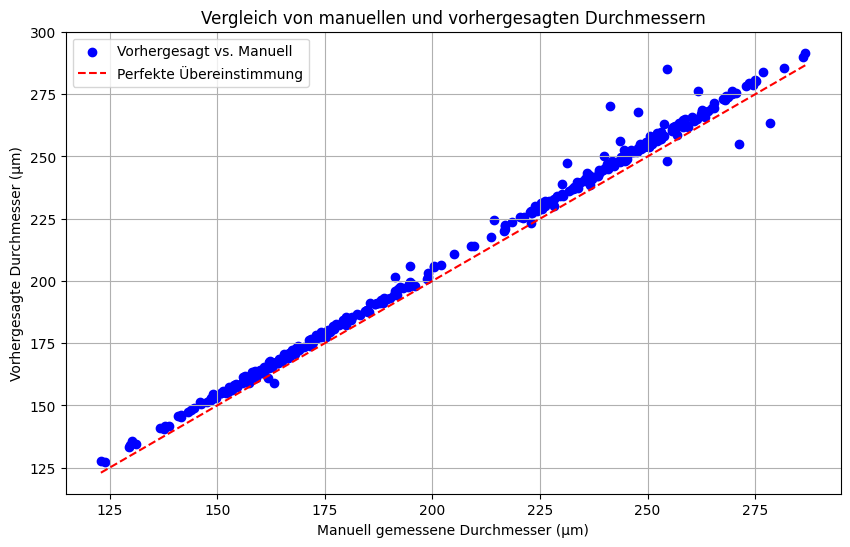

In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Funktion zum Zeichnen von Konturen und Schwerpunkt
def draw_contours_and_centroid(binary_mask, output_path):
    # Finden der Konturen
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Erstellen eines Farbbilds zum Zeichnen
    color_mask = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
    
    # Zeichnen der Konturen
    cv2.drawContours(color_mask, contours, -1, (0, 255, 0), 2)
    
    # Berechnung und Zeichnen des Schwerpunkts
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(color_mask, (cX, cY), 5, (0, 0, 255), -1)
    
    # Speichern des Bildes mit Konturen und Schwerpunkt
    cv2.imwrite(output_path, color_mask)

# Laden und Vorverarbeiten der Bilder mit Pillow
def load_and_preprocess_image_pillow(img_path):
    img = Image.open(img_path).convert('L')  # Convert to grayscale
    img = img.resize((256, 196))  # Größe anpassen (Beispiel: 256x196)
    img = np.array(img)  # PIL Image zu numpy Array konvertieren
    img = img / 255.0  # Normalisierung auf den Bereich [0, 1]
    img = np.expand_dims(img, axis=-1)  # Für einen Kanal (Grayscale)
    return img

# Vorhersage mit dem Modell machen
def predict_with_model(model, image):
    image = np.expand_dims(image, axis=0)  # Batch-Dimension hinzufügen
    predicted_mask = model.predict(image)  # Vorhersage machen
    return np.squeeze(predicted_mask)  # Batch-Dimension entfernen

# Funktion zur Berechnung der mittleren Konturgröße
def calculate_average_contour_size(contour):
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0:
        return 0
    return cv2.contourArea(contour) / perimeter

# Funktion zur Auswahl des besten Schwellenwerts
def find_best_threshold(mask):
    best_threshold = 0
    best_score = 0

    for threshold in np.arange(0.1, 0.5, 0.01):
        binary_mask = (mask > threshold).astype(np.uint8) * 255  # Binarisieren und in 8-bit konvertieren
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            avg_size = calculate_average_contour_size(largest_contour)
            score = avg_size  # Anpassen der Bewertungsmetrik nach Bedarf

            if score > best_score:
                best_score = score
                best_threshold = threshold

    return best_threshold

# Funktion zur Berechnung des mittleren Durchmessers
def calculate_average_diameter(contour, center, num_lines=180):
    angles = np.linspace(0, 2 * np.pi, num=num_lines, endpoint=False)
    diameters = []
    for angle in angles:
        dx = np.cos(angle)
        dy = np.sin(angle)
        intersections = []
        for i in range(-1000, 1000):
            x = int(center[0] + i * dx)
            y = int(center[1] + i * dy)
            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:
                intersections.append((x, y))
        if len(intersections) >= 2:
            d = np.linalg.norm(np.array(intersections[0]) - np.array(intersections[-1]))
            diameters.append(d)
    return np.mean(diameters)

# Pfade definieren
model_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_200_trainingsbilder_noch_komplexer_early_stop_and_droput_3.h5'
input_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Sphäroide BA/Alle BA Sphäaeroidbilder sortiert/'
output_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3 beste bisher/'
excel_file_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Sphäroide BA/gemessene Durchmesser neu.xlsx'

# Modell laden
model = tf.keras.models.load_model(model_path)

# Daten aus der Excel-Tabelle laden
predicted_diameters = []
df_manual = pd.read_excel(excel_file_path, header=0)  # Daten ab der zweiten Zeile 
manual_diameters = df_manual.iloc[:, 1].tolist()  # Durchmesser sind in der zweiten Spalte

# Debug-Ausgabe: Anzahl der manuellen Durchmesser
print(f"Anzahl der manuellen Durchmesser: {len(df_manual)}")

# Skalierungsfaktoren berechnen
scale_factor_width = 1296 / 256  # Originalbreite / skalierte Breite
scale_factor_height = 966 / 196  # Originalhöhe / skalierte Höhe

# Listen für die berechneten Durchmesser und die manuell gemessenen Durchmesser
manual_diameters = []

# Iteration über alle TIFF-Dateien im Eingabeordner
tif_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]

# Debug-Ausgabe: Anzahl der TIFF-Dateien
print(f"Anzahl der TIFF-Dateien: {len(tif_files)}")

# Überprüfen, ob die Anzahl der Dateien mit der Anzahl der manuellen Messungen übereinstimmt
if len(tif_files) != len(df_manual):
    print("Die Anzahl der Bilddateien stimmt nicht mit der Anzahl der manuellen Messungen überein.")
else:
    for i, filename in enumerate(tif_files):
        img_path = os.path.join(input_dir, filename)
        
        try:
            # Bild laden und vorverarbeiten
            image = load_and_preprocess_image_pillow(img_path)
            # Vorhersage mit dem Modell machen
            predicted_mask = predict_with_model(model, image)
            if predicted_mask is None:
                print(f"Fehler bei der Vorhersage für {filename}.")
                continue

            # Besten Schwellenwert für Konturen finden
            best_threshold = find_best_threshold(predicted_mask)

            # Maske mit dem besten Schwellenwert erstellen
            binary_mask = (predicted_mask > best_threshold).astype(np.uint8) * 255  # Binarisieren und in 8-bit konvertieren
            
            # Konturen finden
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

            if not contours:
                print(f"Keine Konturen im Bild {filename} gefunden.")
                continue

            # Filtere Konturen nach Schmalheitsverhältnis
            filtered_contours = []
            for contour in contours:
                area = cv2.contourArea(contour)
                perimeter = cv2.arcLength(contour, True)
                if perimeter == 0:
                    continue
                circularity = 4 * np.pi * (area / (perimeter * perimeter))
                if circularity > 0.5:  # Anpassen des Schmalheitsverhältnisses nach Bedarf
                    filtered_contours.append(contour)

            if not filtered_contours:
                print(f"Keine geeigneten Konturen im Bild {filename} gefunden.")
                continue

            # Die größte Kontur nach dem Flächeninhalt finden
            largest_contour = max(filtered_contours, key=cv2.contourArea)

            # Berechne den Schwerpunkt der Kontur
            M = cv2.moments(largest_contour)
            if M["m00"] == 0:
                print(f"Schwerpunkt konnte im Bild {filename} nicht berechnet werden.")
                continue
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

            # Berechne den mittleren Durchmesser
            avg_diameter_pixels = calculate_average_diameter(largest_contour, center)
            avg_diameter_micrometers = avg_diameter_pixels * (0.3745 * scale_factor_width)

            # Berechnung des Flächeninhalts
            area_pixels = cv2.contourArea(largest_contour)
            area_micrometers = area_pixels * (0.3745 * scale_factor_width * 0.3745 * scale_factor_height)

            # Ergebnisse hinzufügen
            predicted_diameters.append(avg_diameter_micrometers)
            manual_diameters.append(df_manual.iloc[i, 0])  # Manuell gemessener Durchmesser hinzufügen

            # Ausgabepfad für das segmentierte Bild definieren
            output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_segmentiert.tif")
            
            # Maske als TIFF-Datei speichern und Konturen und Schwerpunkt einzeichnen
            draw_contours_and_centroid(binary_mask, output_path)
            print(f"Segmentiertes Bild für {filename} wurde gespeichert.")

            # Ergebnisse ausgeben
            print(f"Bild: {filename}, Durchmesser: {avg_diameter_micrometers:.2f} µm, Flächeninhalt: {area_micrometers:.2f} µm²")

        except Exception as e:
            print(f"Fehler bei der Verarbeitung von {filename}: {e}")

    # Debug-Ausgabe: Anzahl der erfolgreichen Vorhersagen und manuell gemessenen Durchmesser
    print(f"Anzahl der erfolgreichen Vorhersagen: {len(predicted_diameters)}")
    print(f"Anzahl der zugehörigen manuellen Durchmesser: {len(manual_diameters)}")

    # Ergebnisse in ein DataFrame konvertieren
    df_results = pd.DataFrame({
        'Manuell gemessene Durchmesser (µm)': manual_diameters,
        'Vorhergesagte Durchmesser (µm)': predicted_diameters
    })

    # Ergebnisse in eine Excel-Datei exportieren
    excel_output_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Durchmesser Liste mit dropout 3.xlsx'
    df_results.to_excel(excel_output_path, index=False)

    # Berechnung der Metriken zur Bewertung der Modellgenauigkeit
    if len(predicted_diameters) > 0 and len(manual_diameters) > 0:
        mae = mean_absolute_error(manual_diameters, predicted_diameters)
        mse = mean_squared_error(manual_diameters, predicted_diameters)
        r2 = r2_score(manual_diameters, predicted_diameters)

        print(f"\nMetriken zur Bewertung der Modellgenauigkeit:")
        print(f"MAE (Mean Absolute Error): {mae:.2f} µm")
        print(f"MSE (Mean Squared Error): {mse:.2f} µm²")
        print(f"R2 Score (Coefficient of Determination): {r2:.2f}")

        print(f"Ergebnisse und Metriken wurden in {excel_output_path} gespeichert.")
    else:
        print("Keine ausreichenden Daten zur Berechnung der Metriken vorhanden.")

    # Scatterplot erstellen
    plt.figure(figsize=(10, 6))
    plt.scatter(manual_diameters, predicted_diameters, color='blue', label='Vorhergesagt vs. Manuell')
    plt.plot([min(manual_diameters), max(manual_diameters)], [min(manual_diameters), max(manual_diameters)], color='red', linestyle='--', label='Perfekte Übereinstimmung')
    plt.xlabel('Manuell gemessene Durchmesser (µm)')
    plt.ylabel('Vorhergesagte Durchmesser (µm)')
    plt.title('Vergleich von manuellen und vorhergesagten Durchmessern')
    plt.legend()
    plt.grid(True)
    plt.savefig('C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/scatterplot.png')
    plt.show()
